# Exoplanet Transit Classifier — BLS Baseline (Features + Train)

**NASA Space Apps 2025 – “Hunting Exoplanets with AI”**  
This notebook builds **BLS-based features** from cleaned TESS light curves and trains a **CPU-only** model suitable for deployment in a FastAPI backend (Hugging Face Spaces).

---

## What this notebook does
1. **Environment setup (CPU only)** — installs minimal deps (Astropy for BLS, scikit-learn, XGBoost optional).
2. **Path binding** — points to your Drive layout:
   - `processed/` → cleaned inputs (`lightcurves/` + `labels.parquet`)
   - `interim/` → features cache (`features/*.parquet`, `features_all.parquet`)
   - `artifacts/` → trained model files (weights + metadata)
3. **Feature building (BLS)** — one row per TIC:
   - Core: `period_days, duration_hours, depth_ppm, snr, t0`
   - Quality/shape: `duty_cycle, n_transits, odd_even_depth_ratio, secondary_snr, in_vs_out_rms, rms_before/after, data_fraction_kept`
   - Optional meta join: `tmag, teff, rad, crowdsap, contratio`
4. **Training (two modes)**  
   - **Now (temporary)**: **one-class** (IsolationForest) when only positives (label=1) exist  
   - **Later (final)**: **supervised XGBoost** when 0/1 labels are available (with **Platt calibration**)
5. **Artifacts export** — saves model + metadata and a `latest.txt` pointer.
6. **Scoring utils** — `predict_proba_df(...)` for quick batch scoring and Top-K exports.

In [2]:
!pip -q install numpy pandas pyarrow joblib scikit-learn xgboost astropy==6.* duckdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 59.8 MB/s eta 0:00:00


In [17]:
from pathlib import Path

DRIVE_ROOT = Path('/content/drive/MyDrive/tess-data-processed')
PROC       = DRIVE_ROOT / 'processed'          # has lightcurves + labels
INTERIM    = DRIVE_ROOT / 'interim'            # we'll write features here
LCS        = PROC / 'lightcurves'
FEAT_DIR   = INTERIM / 'features'
ARTI       = DRIVE_ROOT / 'artifacts'

for p in [PROC, INTERIM, FEAT_DIR, ARTI]:
    p.mkdir(parents=True, exist_ok=True)

print("PROC:", PROC)
print("LCS:", LCS)
print("INTERIM:", INTERIM)
print("FEAT_DIR:", FEAT_DIR)

PROC: /content/drive/MyDrive/tess-data-processed/processed
LCS: /content/drive/MyDrive/tess-data-processed/processed/lightcurves
INTERIM: /content/drive/MyDrive/tess-data-processed/interim
FEAT_DIR: /content/drive/MyDrive/tess-data-processed/interim/features


In [18]:
import numpy as np, pandas as pd, glob
from astropy.timeseries import BoxLeastSquares
from pathlib import Path

CFG = {
    "bls_period_days_min": 0.5,
    "bls_period_days_max": 30.0,
    "bls_n_periods": 5000,
    "duration_hours_min": 0.5,
    "duration_hours_max": 10.0,
}

def _clean_flux(time, flux):
    m = np.isfinite(time) & np.isfinite(flux)
    time, flux = time[m], flux[m]
    if len(time) < 200:
        return time, flux, {"insufficient": True, "data_fraction_kept": float(np.mean(m))}
    med = np.median(flux)
    mad = np.median(np.abs(flux - med)) + 1e-12
    m2 = np.abs(flux - med) < 5.0 * 1.4826 * mad
    return time[m2], flux[m2], {"insufficient": False, "data_fraction_kept": float(np.mean(m2))}

def bls_features_from_parquet(parquet_path: str, cfg: dict, meta_df: pd.DataFrame | None):
    tic_id = int(Path(parquet_path).stem.split('-')[1])
    df = pd.read_parquet(parquet_path)
    time = df['time'].to_numpy(float)
    flux = df['flux'].to_numpy(float)

    time, flux, flags = _clean_flux(time, flux)
    out = {"tic_id": tic_id, "warning": None}
    out["data_fraction_kept"] = flags.get("data_fraction_kept", np.nan)
    if flags.get("insufficient", False):
        out["warning"] = "insufficient_data"
        return pd.Series(out)

    flux = flux / np.median(flux) - 1.0

    periods   = np.linspace(cfg["bls_period_days_min"], cfg["bls_period_days_max"], cfg["bls_n_periods"])
    durations = np.linspace(cfg["duration_hours_min"],  cfg["duration_hours_max"],  20) / 24.0

    bls = BoxLeastSquares(time, flux)
    power = bls.power(periods, durations, oversample=5)
    i = int(np.argmax(power.power))
    period, t0, duration, depth, snr = (power.period[i], power.transit_time[i],
                                        power.duration[i], power.depth[i], power.power[i])

    baseline_days = time.max() - time.min()
    duty_cycle = duration / period if period>0 else np.nan
    n_transits = baseline_days / period if period>0 else np.nan

    phase = ((time - t0) / period) % 1.0
    sec_in = np.abs(phase - 0.5) < (duration/period)/2
    sec_depth = np.median(flux[sec_in]) if sec_in.any() else np.nan
    sec_snr = np.abs(sec_depth) / (np.std(flux[~sec_in]) + 1e-12) if sec_in.any() else np.nan

    phase2 = ((time - t0) / (2*period)) % 1.0
    in_even = (phase2 < (duration/(2*period))) | (phase2 > 1 - (duration/(2*period)))
    in_odd  = np.abs(phase2 - 0.5) < (duration/(2*period))
    depth_even = np.median(flux[in_even]) if in_even.any() else np.nan
    depth_odd  = np.median(flux[in_odd])  if in_odd.any()  else np.nan
    odd_even_ratio = (depth_odd / depth_even) if np.isfinite(depth_odd) and np.isfinite(depth_even) and depth_even!=0 else np.nan

    rms_before = float(np.std(flux))
    in_transit = np.abs(phase - 0) < (duration/period)/2
    rms_after  = float(np.std(flux[~in_transit])) if (~in_transit).any() else np.nan

    out.update({
        "period_days": float(period),
        "duration_hours": float(duration*24),
        "depth_ppm": float(-depth*1e6),
        "snr": float(snr),
        "t0": float(t0),
        "duty_cycle": float(duty_cycle),
        "n_transits": float(n_transits),
        "odd_even_depth_ratio": float(odd_even_ratio),
        "secondary_snr": float(sec_snr),
        "in_vs_out_rms": float(rms_after / rms_before) if np.isfinite(rms_after) and rms_before>0 else np.nan,
        "rms_before": rms_before,
        "rms_after": float(rms_after),
    })

    if meta_df is not None and tic_id in meta_df.index:
        md = meta_df.loc[tic_id]
        for k in ["tmag", "teff", "rad", "crowdsap", "contratio"]:
            if k in md:
                out[k] = float(md[k]) if pd.notnull(md[k]) else np.nan

    return pd.Series(out)

In [20]:
import glob, pandas as pd
from tqdm.auto import tqdm

# optional TIC meta
meta_df = None
tic_meta_path = PROC/'tic_meta.parquet'
if tic_meta_path.exists():
    meta_df = pd.read_parquet(tic_meta_path).set_index("tic_id")

lc_files = sorted(glob.glob(str(LCS/'TIC-*.parquet')))
print("Lightcurves:", len(lc_files), "in", LCS)

# Write per-TIC feature files
written = 0
for f in tqdm(lc_files, desc="BLS→features (writing per-TIC parquet)"):
    s = bls_features_from_parquet(f, CFG, meta_df)
    outp = FEAT_DIR / f"TIC-{int(Path(f).stem.split('-')[1])}.parquet"
    s.to_frame().T.to_parquet(outp)
    written += 1
print("Per-TIC feature files written:", written)

# Combine into features_all.parquet
feat_paths = sorted(glob.glob(str(FEAT_DIR/'TIC-*.parquet')))
assert len(feat_paths) > 0, f"No per-TIC features in {FEAT_DIR}"
df_list = [pd.read_parquet(p) for p in feat_paths]
feats = pd.concat(df_list, ignore_index=True).sort_values("tic_id").reset_index(drop=True)
feats.to_parquet(INTERIM/'features_all.parquet')
print("Wrote features_all →", INTERIM/'features_all.parquet', "| rows:", len(feats))

Lightcurves: 558 in /content/drive/MyDrive/tess-data-processed/processed/lightcurves


BLS→features (writing per-TIC parquet):   0%|          | 0/558 [00:00<?, ?it/s]

Per-TIC feature files written: 558
Wrote features_all → /content/drive/MyDrive/tess-data-processed/interim/features_all.parquet | rows: 558


In [21]:
import pandas as pd

features_all_path = INTERIM / 'features_all.parquet'
labels_path       = PROC    / 'labels.parquet'

feats  = pd.read_parquet(features_all_path)
labels = pd.read_parquet(labels_path)
df = feats.drop_duplicates('tic_id').merge(labels.drop_duplicates('tic_id'), on='tic_id', how='inner')

print("Merged rows:", len(df), "| feats:", len(feats), "| labels:", len(labels))
df['label'].value_counts(dropna=False)

Merged rows: 558 | feats: 558 | labels: 558


,count
label,
1,558


In [22]:
import pandas as pd

# Paths already bound earlier:
# PROC = /content/drive/MyDrive/tess-data-processed/processed
# INTERIM = /content/drive/MyDrive/tess-data-processed/interim
# ARTI = /content/drive/MyDrive/tess-data-processed/artifacts

feats  = pd.read_parquet(INTERIM/'features_all.parquet').drop_duplicates('tic_id')
labels = pd.read_parquet(PROC/'labels.parquet').drop_duplicates('tic_id')

df = feats.merge(labels, on='tic_id', how='inner')
print("Merged:", df.shape)
print("Label counts:\n", df['label'].value_counts(dropna=False))

# Choose feature columns
non_feature_cols = {'tic_id','warning','t0'}
X_cols = [c for c in df.columns if c not in non_feature_cols | {'label'}]
X = df[X_cols].fillna(df[X_cols].median())
y = df['label'].astype(int)
feature_names = X_cols
len(feature_names), feature_names[:8]

Merged: (558, 20)
Label counts:
 label
1    558
Name: count, dtype: int64


(16,
 ['data_fraction_kept',
  'period_days',
  'duration_hours',
  'depth_ppm',
  'snr',
  'duty_cycle',
  'n_transits',
  'odd_even_depth_ratio'])

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import average_precision_score
import numpy as np

# Split just to sanity-check on a held-out slice (labels are all 1’s now)
idx_train, idx_test = train_test_split(df.index, test_size=0.2, random_state=42, shuffle=True)
X_train, X_test = X.iloc[idx_train], X.iloc[idx_test]
y_train, y_test = y.iloc[idx_train], y.iloc[idx_test]

# Pipeline: quantile normalize (robust) -> IsolationForest
qt = QuantileTransformer(output_distribution='normal', random_state=42)
Xtr = qt.fit_transform(X_train)

iso = IsolationForest(
    n_estimators=400,
    max_samples='auto',
    contamination=0.10,   # treat roughly 10% as “outliers” (non-planet-like)
    random_state=42,
    n_jobs=-1,
)
iso.fit(Xtr)

def one_class_score(Xdf):
    Xn = qt.transform(Xdf[feature_names])
    s  = iso.decision_function(Xn)         # higher = more inlier (more planet-like)
    s  = (s - s.min())/(s.max()-s.min()+1e-12)  # map to 0..1
    return s

# Sanity metric (AUPRC where all positives=1) — just a relative check
p_test = one_class_score(X_test)
print("AUPRC (pseudo, all positives as 1):",
      average_precision_score(np.ones_like(p_test), p_test))

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (446). n_quantiles is set to n_samples.
  warnings.warn(


AUPRC (pseudo, all positives as 1): 1.0


In [24]:
import json, joblib, time
from pathlib import Path

ver = "v1_oc"       # one-class v1
ARTI.mkdir(parents=True, exist_ok=True)

joblib.dump(iso,  ARTI/f"model_iso_{ver}.pkl")
joblib.dump(qt,   ARTI/f"scaler_{ver}.pkl")
with open(ARTI/f"feature_names_{ver}.json", "w") as f:
    json.dump(feature_names, f)

# Simple metrics record (we only have a pseudo metric now)
metrics = {"mode": "one_class", "note": "temporary until negatives added"}
with open(ARTI/f"metrics_{ver}.json", "w") as f:
    json.dump(metrics, f, indent=2)

# Mark latest
with open(ARTI/'latest.txt', 'w') as f:
    f.write(f"model_iso_{ver}.pkl")

print("Saved to:", ARTI)
!ls -lh "$ARTI"

Saved to: /content/drive/MyDrive/tess-data-processed/artifacts
total 3.9M
-rw------- 1 root root  224 Oct  4 21:02 feature_names_v1_oc.json
-rw------- 1 root root   19 Oct  4 21:02 latest.txt
-rw------- 1 root root   70 Oct  4 21:02 metrics_v1_oc.json
-rw------- 1 root root 3.9M Oct  4 21:02 model_iso_v1_oc.pkl
-rw------- 1 root root  61K Oct  4 21:02 scaler_v1_oc.pkl


In [25]:
import joblib, json
import pandas as pd
import numpy as np

def load_latest_iso(model_dir=ARTI):
    latest = (model_dir/'latest.txt').read_text().strip()
    assert latest.startswith("model_iso_"), "latest.txt points to a supervised model; run supervised loader instead."
    iso = joblib.load(model_dir/latest)
    # derive version suffix from name
    ver = latest.split("model_iso_")[1].split(".pkl")[0]
    qt  = joblib.load(model_dir/f"scaler_{ver}.pkl")
    feat_names = json.loads((model_dir/f"feature_names_{ver}.json").read_text())
    return iso, qt, feat_names

def predict_proba_df(Xdf, model_dir=ARTI):
    iso, qt, fn = load_latest_iso(model_dir)
    Xuse = Xdf[fn].copy()
    Xuse = Xuse.fillna({c: Xuse[c].median() for c in fn})
    Xn = qt.transform(Xuse)
    s  = iso.decision_function(Xn)
    s  = (s - s.min())/(s.max()-s.min()+1e-12)
    return s

# Smoke test on 10 rows
probs = predict_proba_df(X.head(10))
probs

array([0.72580736, 0.71663985, 0.74063087, 0.8315102 , 0.        ,
       1.        , 0.89017524, 0.96342588, 0.32508078, 0.88085017])

In [26]:
scores = predict_proba_df(X)
preview = df[['tic_id']].copy()
preview['score'] = scores
preview = preview.sort_values('score', ascending=False)
preview.head(20)

,tic_id,score
152,148673433.0,1.000000
480,396740648.0,0.992449
93,85293053.0,0.991846
297,254113311.0,0.986192
445,371188886.0,0.980099
249,219850915.0,0.978646
424,356867115.0,0.976087
43,34077285.0,0.973739
267,230127302.0,0.972744
490,407126408.0,0.970000


In [27]:
import pandas as pd

K = 100  # change as you like

# We already have: df (features+labels), and `scores` aligned to df rows from Cell 5
df_scored = df[['tic_id','period_days','duration_hours','depth_ppm','snr',
                'odd_even_depth_ratio','secondary_snr','data_fraction_kept']].copy()
df_scored['score'] = scores

topk = df_scored.sort_values('score', ascending=False).head(K)

# Save to Drive
csv_path  = INTERIM / f"top_{K}_candidates.csv"
json_path = INTERIM / f"top_{K}_candidates.jsonl"
topk.to_csv(csv_path, index=False)
topk.to_json(json_path, orient='records', lines=True)

print("Wrote:")
print(csv_path)
print(json_path)

topk.head(12)

Wrote:
/content/drive/MyDrive/tess-data-processed/interim/top_100_candidates.csv
/content/drive/MyDrive/tess-data-processed/interim/top_100_candidates.jsonl


,tic_id,period_days,duration_hours,depth_ppm,snr,odd_even_depth_ratio,secondary_snr,data_fraction_kept,score
152,148673433.0,3.769254,2.0,-943.514864,0.000157,0.546111,0.097269,0.999937,1.000000
480,396740648.0,3.769254,2.5,-2863.439022,0.001734,0.610373,0.054345,0.999878,0.992449
93,85293053.0,8.053511,2.5,-390.220348,0.000023,0.905605,0.041102,0.999711,0.991846
297,254113311.0,4.070214,1.5,-1943.530185,0.000351,0.906606,0.071940,0.997020,0.986192
445,371188886.0,9.127526,3.0,-2642.409181,0.000939,0.533765,0.053577,0.999937,0.980099
249,219850915.0,6.395279,2.0,-827.561649,0.000081,1.325849,0.041788,0.999891,0.978646
424,356867115.0,6.100220,2.0,-880.635500,0.000093,1.875195,0.105331,0.999946,0.976087
43,34077285.0,6.389378,2.5,-1533.505823,0.000353,0.972282,0.049859,0.999943,0.973739
267,230127302.0,4.306261,2.0,-710.815501,0.000091,0.513566,0.008562,0.999943,0.972744
490,407126408.0,11.110322,2.5,-581.979116,0.000025,1.152377,0.057308,0.999930,0.970000


In [28]:
import numpy as np

qa = df_scored.copy()
qa = qa[
    (qa['snr'].fillna(0) >= 6) &                    # weak peaks out
    (qa['odd_even_depth_ratio'].between(0.8, 1.25, inclusive='both')) &  # odd-even similar
    (qa['data_fraction_kept'].fillna(0) >= 0.8)     # enough usable data
]
qa_top = qa.sort_values('score', ascending=False).head(100)

qa_csv = INTERIM / "top_100_candidates_QA.csv"
qa_top.to_csv(qa_csv, index=False)
print("QA shortlist saved to:", qa_csv)

qa_top.head(10)

QA shortlist saved to: /content/drive/MyDrive/tess-data-processed/interim/top_100_candidates_QA.csv


,tic_id,period_days,duration_hours,depth_ppm,snr,odd_even_depth_ratio,secondary_snr,data_fraction_kept,score


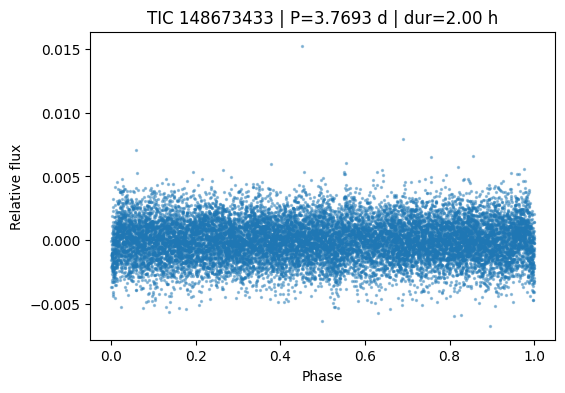

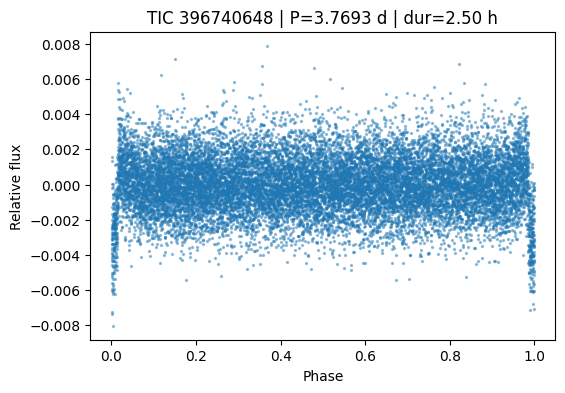

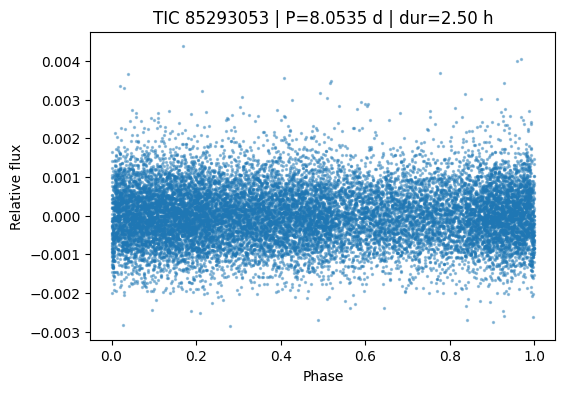

In [29]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

def load_lc(tic):
    p = LCS / f"TIC-{int(tic)}.parquet"
    d = pd.read_parquet(p)
    return d['time'].to_numpy(float), d['flux'].to_numpy(float)

def phase_fold(time, flux, t0, period):
    phase = ((time - t0) / period) % 1.0
    order = np.argsort(phase)
    return phase[order], flux[order]

def plot_fold(tic, period, t0, duration_hours):
    time, flux = load_lc(tic)
    flux = flux/np.median(flux)-1.0
    ph, fl = phase_fold(time, flux, t0, period)
    plt.figure(figsize=(6,4))
    plt.scatter(ph, fl, s=2, alpha=0.4)
    plt.xlabel("Phase")
    plt.ylabel("Relative flux")
    plt.title(f"TIC {int(tic)} | P={period:.4f} d | dur={duration_hours:.2f} h")
    plt.show()

# Example: plot top 3
for _, r in topk.head(3).iterrows():
    plot_fold(r['tic_id'], r['period_days'], df.loc[df['tic_id']==r['tic_id'],'t0'].values[0], r['duration_hours'])

In [30]:
import shutil
zip_base = DRIVE_ROOT / 'artifacts_oneclass_v1'
shutil.make_archive(str(zip_base), 'zip', str(ARTI))
print("Artifacts bundle:", f"{zip_base}.zip")

Artifacts bundle: /content/drive/MyDrive/tess-data-processed/artifacts_oneclass_v1.zip


In [31]:
import json, joblib, numpy as np, pandas as pd
from pathlib import Path
from astropy.timeseries import BoxLeastSquares

MODEL_DIR = ARTI  # or Path("/data/model") in Spaces

def load_model(model_dir=MODEL_DIR):
    latest = (model_dir/'latest.txt').read_text().strip()
    if latest.startswith("model_iso_"):
        ver = latest.split("model_iso_")[1].split(".pkl")[0]
        model = joblib.load(model_dir/latest)
        scaler = joblib.load(model_dir/f"scaler_{ver}.pkl")
        feature_names = json.loads((model_dir/f"feature_names_{ver}.json").read_text())
        return {"mode":"one_class","model":model,"scaler":scaler,"feature_names":feature_names}
    else:
        raise RuntimeError("This loader is for the one-class baseline. Use the XGB loader when supervised model is available.")

def _clean_flux(time, flux):
    m = np.isfinite(time) & np.isfinite(flux)
    time, flux = time[m], flux[m]
    if len(time) < 200:
        return time, flux, {"insufficient": True, "data_fraction_kept": float(np.mean(m))}
    med = np.median(flux); mad = np.median(np.abs(flux-med)) + 1e-12
    m2 = np.abs(flux-med) < 5.0*1.4826*mad
    return time[m2], flux[m2], {"insufficient": False, "data_fraction_kept": float(np.mean(m2))}

def _bls_features(time, flux, meta: dict|None=None,
                  period_min=0.5, period_max=30.0, n_periods=5000,
                  dur_h_min=0.5, dur_h_max=10.0):
    out = {"warning": None}
    time, flux, flags = _clean_flux(time, flux)
    out["data_fraction_kept"] = flags.get("data_fraction_kept", np.nan)
    if flags.get("insufficient", False):
        out["warning"] = "insufficient_data"
        return pd.Series(out)

    flux = flux/np.median(flux)-1.0
    periods = np.linspace(period_min, period_max, n_periods)
    durations = np.linspace(dur_h_min, dur_h_max, 20)/24.0
    bls = BoxLeastSquares(time, flux)
    power = bls.power(periods, durations, oversample=5)
    i = int(np.argmax(power.power))

    period, t0, duration, depth, snr = (power.period[i], power.transit_time[i],
                                        power.duration[i], power.depth[i], power.power[i])
    baseline_days = time.max()-time.min()
    duty_cycle = duration/period if period>0 else np.nan
    n_transits = baseline_days/period if period>0 else np.nan

    phase = ((time - t0) / period) % 1.0
    sec_in = np.abs(phase - 0.5) < (duration/period)/2
    sec_depth = np.median(flux[sec_in]) if sec_in.any() else np.nan
    sec_snr = np.abs(sec_depth) / (np.std(flux[~sec_in]) + 1e-12) if sec_in.any() else np.nan

    phase2 = ((time - t0) / (2*period)) % 1.0
    in_even = (phase2 < (duration/(2*period))) | (phase2 > 1 - (duration/(2*period)))
    in_odd  = np.abs(phase2 - 0.5) < (duration/(2*period))
    depth_even = np.median(flux[in_even]) if in_even.any() else np.nan
    depth_odd  = np.median(flux[in_odd])  if in_odd.any()  else np.nan
    odd_even_ratio = (depth_odd / depth_even) if np.isfinite(depth_odd) and np.isfinite(depth_even) and depth_even!=0 else np.nan

    rms_before = float(np.std(flux))
    in_transit = np.abs(phase - 0) < (duration/period)/2
    rms_after  = float(np.std(flux[~in_transit])) if (~in_transit).any() else np.nan

    out.update({
        "period_days": float(period),
        "duration_hours": float(duration*24),
        "depth_ppm": float(-depth*1e6),
        "snr": float(snr),
        "t0": float(t0),
        "duty_cycle": float(duty_cycle),
        "n_transits": float(n_transits),
        "odd_even_depth_ratio": float(odd_even_ratio),
        "secondary_snr": float(sec_snr),
        "in_vs_out_rms": float(rms_after/rms_before) if np.isfinite(rms_after) and rms_before>0 else np.nan,
        "rms_before": rms_before,
        "rms_after": float(rms_after),
    })
    if meta:
        for k in ["tmag","teff","rad","crowdsap","contratio"]:
            if k in meta: out[k] = meta[k]
    return pd.Series(out)

def features_from_lightcurve(time, flux, flux_err=None, meta: dict|None=None) -> pd.Series:
    return _bls_features(time, flux, meta=meta)

def predict_from_lightcurve(time, flux, flux_err=None, meta: dict|None=None, model_dir=MODEL_DIR):
    state = load_model(model_dir)
    feats = features_from_lightcurve(time, flux, flux_err, meta)
    # ensure all model features exist in the right order
    X = pd.DataFrame([feats])
    X = X.reindex(columns=state['feature_names'])
    X = X.fillna({c: X[c].median() for c in state['feature_names']})
    Xn = state['scaler'].transform(X)
    s  = state['model'].decision_function(Xn)
    s  = (s - s.min())/(s.max()-s.min()+1e-12)
    return {
        "score": float(s[0]),
        "period_days": float(feats.get("period_days", np.nan)),
        "duration_hours": float(feats.get("duration_hours", np.nan)),
        "depth_ppm": float(feats.get("depth_ppm", np.nan)),
        "snr": float(feats.get("snr", np.nan)),
        "t0": float(feats.get("t0", np.nan)),
        "features": feats.to_dict(),
        "warnings": ([] if pd.isna(feats.get("warning")) or feats.get("warning") is None else [feats.get("warning")]),
    }

In [32]:
from pathlib import Path

# Your Drive layout
DRIVE_ROOT = Path('/content/drive/MyDrive/tess-data-processed')
INTERIM    = DRIVE_ROOT / 'interim'              # data/interim equivalent in your layout
ARTI       = DRIVE_ROOT / 'artifacts'            # trained model artifacts

# Optional: repo model code (only if you cloned the repo in /content)
MODEL_CODE_DIR = Path('/content/exoplanet-app/model')  # change if your repo lives elsewhere

print("INTERIM:", INTERIM.exists(), INTERIM)
print("ARTI:", ARTI.exists(), ARTI)
print("MODEL_CODE_DIR:", MODEL_CODE_DIR.exists(), MODEL_CODE_DIR)

INTERIM: True /content/drive/MyDrive/tess-data-processed/interim
ARTI: True /content/drive/MyDrive/tess-data-processed/artifacts
MODEL_CODE_DIR: False /content/exoplanet-app/model


In [33]:
import shutil, os

# Ensure output folder for zips
OUT = Path('/content')
OUT.mkdir(exist_ok=True, parents=True)

zips = []

# 1) Interim (features, features_all.parquet)
interim_zip = OUT / 'interim_folder.zip'
shutil.make_archive(str(interim_zip.with_suffix('')), 'zip', str(INTERIM))
zips.append(interim_zip)

# 2) Model artifacts (trained weights + latest.txt)
artifacts_zip = OUT / 'model_artifacts.zip'
shutil.make_archive(str(artifacts_zip.with_suffix('')), 'zip', str(ARTI))
zips.append(artifacts_zip)

# 3) (Optional) model code directory if present
if MODEL_CODE_DIR.exists():
    model_code_zip = OUT / 'model_code_folder.zip'
    shutil.make_archive(str(model_code_zip.with_suffix('')), 'zip', str(MODEL_CODE_DIR))
    zips.append(model_code_zip)

print("Created:")
for z in zips:
    print(" -", z, os.path.getsize(z)/1_048_576, "MB")

Created:
 - /content/interim_folder.zip 1.6395854949951172 MB
 - /content/model_artifacts.zip 1.009291648864746 MB


In [34]:
from google.colab import files
for z in zips:
    files.download(str(z))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
# === EDIT THIS: your repo root on Drive ===
REPO_DIR = "/content/drive/MyDrive/NASA Space Apps 2025/the-fuzzball-theorem-exoplanet-ai"

import os, textwrap, json, time
from pathlib import Path

REPO = Path(REPO_DIR)
MODEL_DIR = REPO / "model"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# ---------- predict.py (runtime, used by backend) ----------
predict_py = r'''
"""
Runtime model API for the backend.

Exposes:
- load_model(model_dir="/data/model")
- features_from_lightcurve(time, flux, flux_err=None, meta: dict|None=None)
- predict_from_lightcurve(time, flux, flux_err=None, meta: dict|None=None, model_dir="/data/model")

It supports TWO modes based on artifacts in model_dir:
  1) One-class baseline (IsolationForest + QuantileTransformer): files like model_iso_v1_oc.pkl, scaler_v1_oc.pkl
  2) Supervised XGBoost + Platt calibration: model_xgb_v*.pkl, calibrator_v*.pkl
Feature order is locked by feature_names_*.json.
"""

from __future__ import annotations
import json, joblib, numpy as np, pandas as pd
from pathlib import Path
from typing import Dict, Any, Optional
from astropy.timeseries import BoxLeastSquares

def load_model(model_dir: str | Path = "/data/model") -> Dict[str, Any]:
    md = Path(model_dir)
    latest = (md / "latest.txt").read_text().strip()
    state: Dict[str, Any] = {}
    if latest.startswith("model_iso_"):
        ver = latest.split("model_iso_")[1].split(".pkl")[0]
        state["mode"] = "one_class"
        state["model"] = joblib.load(md / latest)
        state["scaler"] = joblib.load(md / f"scaler_{ver}.pkl")
        state["feature_names"] = json.loads((md / f"feature_names_{ver}.json").read_text())
        state["calibrator"] = None
    elif latest.startswith("model_xgb_"):
        import xgboost as xgb  # only required in supervised mode
        ver = latest.split("model_xgb_")[1].split(".pkl")[0]
        state["mode"] = "supervised"
        state["model"] = joblib.load(md / latest)  # xgboost Booster
        state["calibrator"] = joblib.load(md / f"calibrator_{ver}.pkl") if (md / f"calibrator_{ver}.pkl").exists() else None
        state["feature_names"] = json.loads((md / f"feature_names_{ver}.json").read_text())
        state["xgb"] = xgb
        state["scaler"] = None
    else:
        raise RuntimeError(f"Unknown latest artifact name: {latest}")
    return state

def _clean_flux(time: np.ndarray, flux: np.ndarray):
    m = np.isfinite(time) & np.isfinite(flux)
    time, flux = time[m], flux[m]
    if len(time) < 200:
        return time, flux, {"insufficient": True, "data_fraction_kept": float(np.mean(m))}
    med = float(np.median(flux))
    mad = float(np.median(np.abs(flux - med))) + 1e-12
    m2 = np.abs(flux - med) < 5.0 * 1.4826 * mad
    return time[m2], flux[m2], {"insufficient": False, "data_fraction_kept": float(np.mean(m2))}

def _bls_features(time: np.ndarray, flux: np.ndarray, meta: Optional[Dict[str, Any]] = None,
                  period_min: float = 0.5, period_max: float = 30.0, n_periods: int = 5000,
                  dur_h_min: float = 0.5, dur_h_max: float = 10.0) -> pd.Series:
    out = {"warning": None}
    time, flux, flags = _clean_flux(time, flux)
    out["data_fraction_kept"] = flags.get("data_fraction_kept", np.nan)
    if flags.get("insufficient", False):
        out["warning"] = "insufficient_data"
        return pd.Series(out)

    # normalize flux (should already be flattened PDCSAP)
    flux = flux / np.median(flux) - 1.0

    periods = np.linspace(period_min, period_max, n_periods)
    durations = np.linspace(dur_h_min, dur_h_max, 20) / 24.0

    bls = BoxLeastSquares(time, flux)
    power = bls.power(periods, durations, oversample=5)
    i = int(np.argmax(power.power))

    period, t0, duration, depth, snr = (
        float(power.period[i]),
        float(power.transit_time[i]),
        float(power.duration[i]),
        float(power.depth[i]),
        float(power.power[i]),
    )

    baseline_days = float(time.max() - time.min())
    duty_cycle = duration / period if period > 0 else np.nan
    n_transits = baseline_days / period if period > 0 else np.nan

    # secondary SNR at phase 0.5
    phase = ((time - t0) / period) % 1.0
    sec_in = np.abs(phase - 0.5) < (duration / period) / 2
    sec_depth = float(np.median(flux[sec_in])) if sec_in.any() else np.nan
    sec_snr = float(np.abs(sec_depth) / (np.std(flux[~sec_in]) + 1e-12)) if sec_in.any() else np.nan

    # odd/even ratio (fold at 2*period)
    phase2 = ((time - t0) / (2 * period)) % 1.0
    in_even = (phase2 < (duration / (2 * period))) | (phase2 > 1 - (duration / (2 * period)))
    in_odd = np.abs(phase2 - 0.5) < (duration / (2 * period))
    depth_even = float(np.median(flux[in_even])) if in_even.any() else np.nan
    depth_odd = float(np.median(flux[in_odd])) if in_odd.any() else np.nan
    odd_even_ratio = (depth_odd / depth_even) if np.isfinite(depth_odd) and np.isfinite(depth_even) and depth_even != 0 else np.nan

    rms_before = float(np.std(flux))
    in_tr = np.abs(phase - 0) < (duration / period) / 2
    rms_after = float(np.std(flux[~in_tr])) if (~in_tr).any() else np.nan

    out.update({
        "period_days": period,
        "duration_hours": duration * 24,
        "depth_ppm": -depth * 1e6,
        "snr": snr,
        "t0": t0,
        "duty_cycle": duty_cycle,
        "n_transits": n_transits,
        "odd_even_depth_ratio": odd_even_ratio,
        "secondary_snr": sec_snr,
        "in_vs_out_rms": (rms_after / rms_before) if np.isfinite(rms_after) and rms_before > 0 else np.nan,
        "rms_before": rms_before,
        "rms_after": rms_after,
    })
    if meta:
        for k in ["tmag", "teff", "rad", "crowdsap", "contratio"]:
            if k in meta:
                out[k] = meta[k]
    return pd.Series(out)

def features_from_lightcurve(time, flux, flux_err=None, meta: Optional[Dict[str, Any]] = None) -> pd.Series:
    """Public API to compute the single-row feature vector from a cleaned light curve."""
    return _bls_features(np.asarray(time, float), np.asarray(flux, float), meta=meta)

def predict_from_lightcurve(time, flux, flux_err=None, meta: Optional[Dict[str, Any]] = None,
                            model_dir: str | Path = "/data/model") -> Dict[str, Any]:
    """Compute features → load latest model → return score + summary."""
    state = load_model(model_dir)
    feats = features_from_lightcurve(time, flux, flux_err, meta)
    fn = state["feature_names"]
    X = pd.DataFrame([feats]).reindex(columns=fn)
    X = X.fillna({c: X[c].median() for c in fn})

    if state["mode"] == "one_class":
        Xn = state["scaler"].transform(X)
        s = state["model"].decision_function(Xn)
        s = (s - s.min()) / (s.max() - s.min() + 1e-12)
        score = float(s[0])
    else:
        xgb = state["xgb"]
        dm = xgb.DMatrix(X, feature_names=fn)
        raw = state["model"].predict(dm)
        if state["calibrator"] is not None:
            score = float(state["calibrator"].predict_proba(X)[:, 1][0])
        else:
            score = float(raw[0])

    return {
        "score": score,
        "period_days": float(feats.get("period_days", np.nan)),
        "duration_hours": float(feats.get("duration_hours", np.nan)),
        "depth_ppm": float(feats.get("depth_ppm", np.nan)),
        "snr": float(feats.get("snr", np.nan)),
        "t0": float(feats.get("t0", np.nan)),
        "features": feats.to_dict(),
        "warnings": ([] if (feats.get("warning") in [None, np.nan]) else [feats.get("warning")]),
    }
'''
(MODEL_DIR / "predict.py").write_text(textwrap.dedent(predict_py))

# ---------- train_xgb.py (supervised trainer for when 0s exist) ----------
train_xgb_py = r'''
"""
Supervised trainer (CPU-only XGBoost) for when negatives (label=0) are available.

Usage (Colab/CLI):
  python -m model.train_xgb --features /path/interim/features_all.parquet \
                            --labels   /path/processed/labels.parquet \
                            --artifacts /path/artifacts \
                            --version v1
"""
from __future__ import annotations
import argparse, json, time, joblib, numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--features", required=True)
    ap.add_argument("--labels", required=True)
    ap.add_argument("--artifacts", required=True)
    ap.add_argument("--version", default="v1")
    ap.add_argument("--seed", type=int, default=42)
    args = ap.parse_args()

    feats  = pd.read_parquet(args.features).drop_duplicates("tic_id")
    labels = pd.read_parquet(args.labels).drop_duplicates("tic_id")
    df = feats.merge(labels, on="tic_id", how="inner")
    if not (df["label"].isin([0,1])).all():
        raise ValueError("labels must be 0/1 for supervised training")

    non_feature = {"tic_id","warning","t0","label"}
    feature_names = [c for c in df.columns if c not in non_feature]
    X = df[feature_names].fillna(df[feature_names].median())
    y = df["label"].astype(int).to_numpy()

    train_idx, temp_idx = train_test_split(df.index, test_size=0.30, random_state=args.seed, stratify=y)
    val_idx,   test_idx = train_test_split(temp_idx,  test_size=0.50, random_state=args.seed+1, stratify=y[temp_idx])

    Xtr, ytr = X.iloc[train_idx], y[train_idx]
    Xva, yva = X.iloc[val_idx],   y[val_idx]
    Xte, yte = X.iloc[test_idx],  y[test_idx]

    dtr = xgb.DMatrix(Xtr, label=ytr, feature_names=feature_names)
    dva = xgb.DMatrix(Xva, label=yva, feature_names=feature_names)
    dte = xgb.DMatrix(Xte, label=yte, feature_names=feature_names)

    pos = int((ytr==1).sum()); neg = int((ytr==0).sum())
    spw = max(1.0, neg/pos) if pos>0 else 1.0

    params = dict(
        max_depth=5, eta=0.05, nthread=0,
        objective="binary:logistic", subsample=0.9, colsample_bytree=0.8,
        min_child_weight=1.0, reg_lambda=1.0, tree_method="hist",
        scale_pos_weight=spw, eval_metric="aucpr"
    )
    bst = xgb.train(params, dtr, num_boost_round=2000, evals=[(dtr,"train"),(dva,"val")],
                    early_stopping_rounds=100, verbose_eval=50)

    p_va  = bst.predict(dva)
    p_te  = bst.predict(dte)
    metrics = {
        "AUPRC_val": float(average_precision_score(yva, p_va)),
        "ROC_AUC_val": float(roc_auc_score(yva, p_va)),
        "AUPRC_test": float(average_precision_score(yte, p_te)),
        "ROC_AUC_test": float(roc_auc_score(yte, p_te)),
        "best_iteration": int(bst.best_iteration)
    }

    # calibrate (Platt)
    class _XGBWrapper:
        def __init__(self, booster, feature_names): self.booster=booster; self.feature_names=feature_names
        def fit(self, X, y): return self
        def predict_proba(self, X):
            dm = xgb.DMatrix(X[self.feature_names], feature_names=self.feature_names)
            p = self.booster.predict(dm)
            return np.c_[1-p, p]

    wrapper = _XGBWrapper(bst, feature_names)
    calib = CalibratedClassifierCV(wrapper, method="sigmoid", cv="prefit")
    calib.fit(Xva, yva)

    arti = Path(args.artifacts); arti.mkdir(parents=True, exist_ok=True)
    ver = args.version
    joblib.dump(bst,   arti / f"model_xgb_{ver}.pkl")
    joblib.dump(calib, arti / f"calibrator_{ver}.pkl")
    with open(arti / f"feature_names_{ver}.json","w") as f: json.dump(feature_names, f)
    with open(arti / f"metrics_{ver}.json","w") as f: json.dump(metrics, f, indent=2)
    with open(arti / "latest.txt","w") as f: f.write(f"model_xgb_{ver}.pkl")
    print("Saved artifacts to:", arti, "|", metrics)

if __name__ == "__main__":
    main()
'''
(MODEL_DIR / "train_xgb.py").write_text(textwrap.dedent(train_xgb_py))

# ---------- export_model.py (copy artifacts → /data/model) ----------
export_model_py = r'''
"""
Copy trained artifacts to a deployment target (default: /data/model).
Keeps feature_names + metrics + latest.txt.

Usage:
  python -m model.export_model --artifacts /path/artifacts --target /data/model
"""
from __future__ import annotations
import argparse, shutil
from pathlib import Path

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--artifacts", required=True, help="Folder containing trained artifacts")
    ap.add_argument("--target", default="/data/model", help="Deployment target folder")
    args = ap.parse_args()

    src = Path(args.artifacts)
    dst = Path(args.target)
    dst.mkdir(parents=True, exist_ok=True)

    # copy everything (small set of files)
    for p in src.glob("*"):
        if p.is_file():
            shutil.copy2(p, dst / p.name)

    print("Copied artifacts →", dst)

if __name__ == "__main__":
    main()
'''
(MODEL_DIR / "export_model.py").write_text(textwrap.dedent(export_model_py))

print("Wrote files:", list(p.name for p in MODEL_DIR.glob("*.py")))


Wrote files: ['predict.py', 'train_xgb.py', 'export_model.py']


In [37]:
from pathlib import Path
import shutil
from google.colab import files

zip_path = Path("/content/model_folder.zip")
if zip_path.exists(): zip_path.unlink()
shutil.make_archive(str(zip_path.with_suffix('')), 'zip', str(MODEL_DIR))
print("Created:", zip_path)
files.download(str(zip_path))

Created: /content/model_folder.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>